In [15]:
from helpers import load_dataset_paths
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from preprocessing import preprocess_signal, load_signal
import os

## Preprocess and save all signals

In [ ]:
# BASE_DIR = "MATLAB_prep/Labelled_VEP_Data"
# DEVICES = ["PRIMA", "MP20"]
# LABELS = ["BC_Only", "RGC_Only", "BC_and_RGC"]

# OUTPUT_DIR = "Preprocessed_VEP_Data"

# all_paths = load_dataset_paths(base_dir=BASE_DIR, devices=DEVICES, labels=LABELS)

# prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
# prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
# prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]

# mp20_files_BC_only = all_paths["MP20"]["BC_Only"]
# mp20_files_RGC_only = all_paths["MP20"]["RGC_Only"]
# mp20_files_BC_and_RGC = all_paths["MP20"]["BC_and_RGC"]

# for device, label_dict in all_paths.items():
#     for label, file_list in label_dict.items():
#         output_subdir = os.path.join(OUTPUT_DIR, device, label)
#         os.makedirs(output_subdir, exist_ok=True)
        
#         for file_path in file_list:
#             time_preprocessed, signal_preprocessed = preprocess_signal(file_path)
#             # save under exactely the same filename in the new directory structure
#             filename = os.path.basename(file_path)
#             output_path = os.path.join(output_subdir, filename)
#             # save as csv
#             df = pd.DataFrame({'Time': time_preprocessed, 'Signal': signal_preprocessed})
#             df.to_csv(output_path, index=False)

## Test pipeline

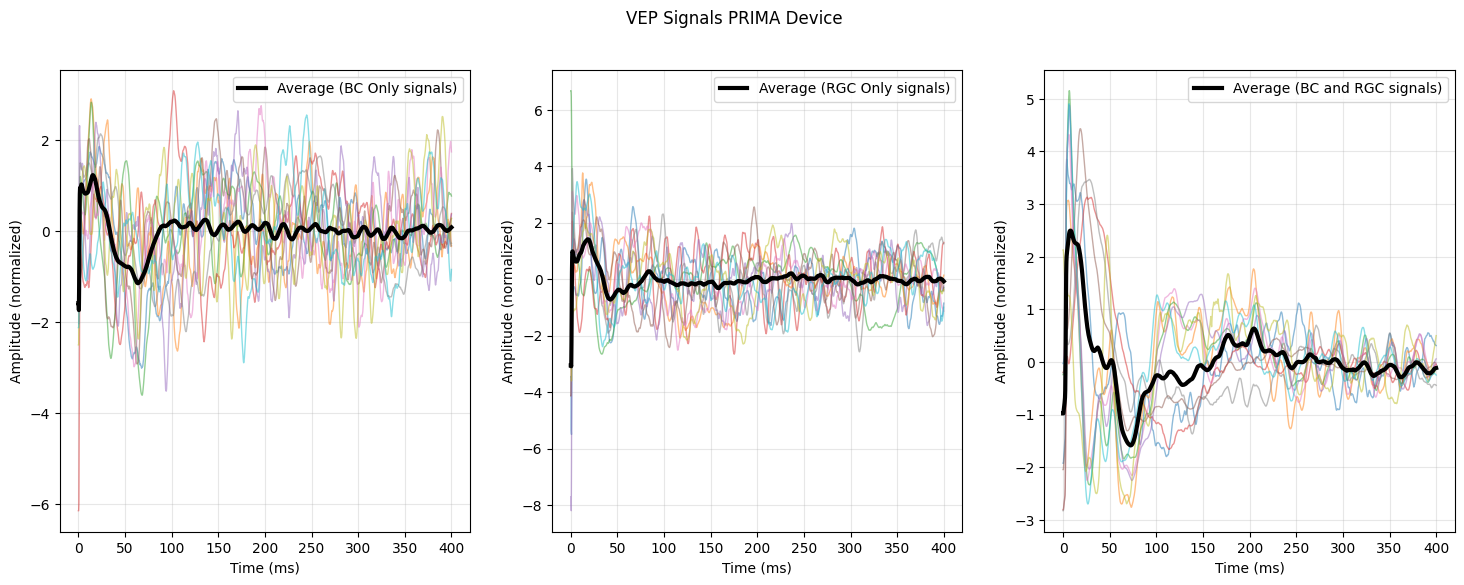

In [3]:
# get ch1 and ch3 data 
BASE_DIR = "MATLAB_prep/Labelled_VEP_Data"
DEVICES = ["PRIMA", "MP20"]
LABELS = ["BC_Only", "RGC_Only", "BC_and_RGC"]

all_paths = load_dataset_paths(base_dir=BASE_DIR, devices=DEVICES, labels=LABELS)

prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]


def compute_average_for_files(file_list):
    signals = []
    for file in file_list:
        time, signal = preprocess_signal(file)
        signals.append(signal)
    avg_sig = np.mean(signals, axis=0)
    avg_t = time
    return avg_t, avg_sig

# Compute averages for each category
avg_BC_t, avg_BC_sig = compute_average_for_files(prima_files_BC_only)
avg_RGC_t, avg_RGC_sig = compute_average_for_files(prima_files_RGC_only)
avg_BC_RGC_t, avg_BC_RGC_sig = compute_average_for_files(prima_files_BC_and_RGC)


# --- Choose 3 example files per category ---
example_files_BC = prima_files_BC_only[:10]
example_files_RGC = prima_files_RGC_only[:10]
example_files_BC_and_RGC = prima_files_BC_and_RGC[:10]

categories = [
    (example_files_BC, "BC Only", avg_BC_t, avg_BC_sig),
    (example_files_RGC, "RGC Only", avg_RGC_t, avg_RGC_sig),
    (example_files_BC_and_RGC, "BC and RGC", avg_BC_RGC_t, avg_BC_RGC_sig)
]

# --- Plot ---
plt.figure(figsize=(18, 6))
plt.suptitle("VEP Signals PRIMA Device")
for i, (file_list, title, avg_t, avg_sig) in enumerate(categories, 1):
    plt.subplot(1, 3, i)

    # Plot some example signals
    for file in file_list:
        time, signal = preprocess_signal(file)
        plt.plot(time, signal, alpha=0.5, lw=1)

    # Plot the class-wide average in black
    plt.plot(avg_t, avg_sig, color="k", lw=3, label=f"Average ({title} signals)")

    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
plt.show()

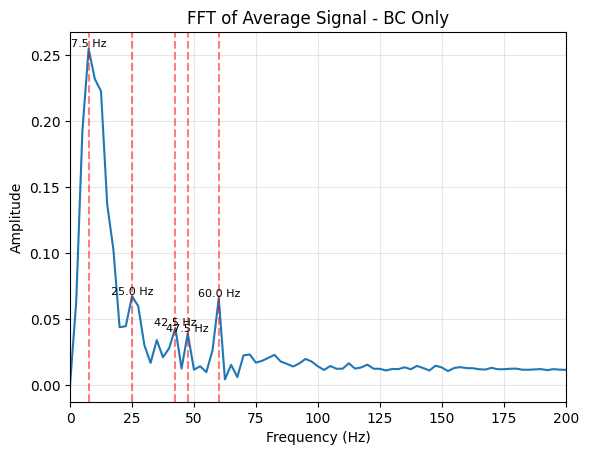

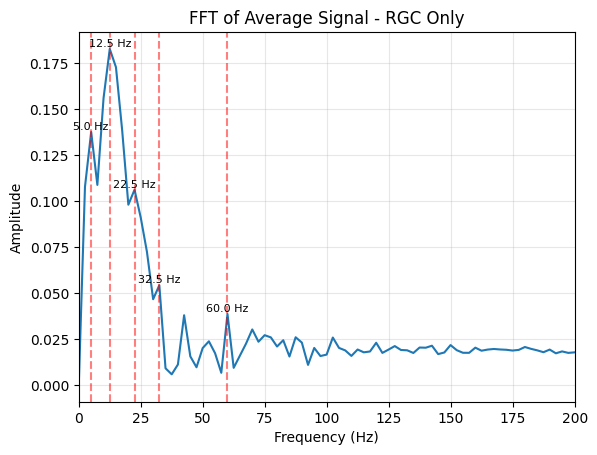

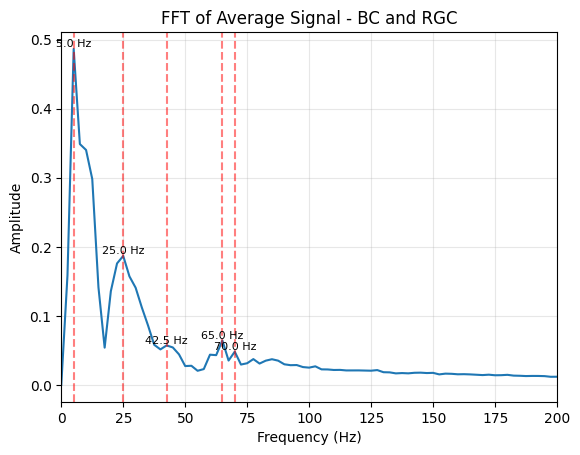

In [4]:
# plot fft of average signals
from scipy.fft import fft, fftfreq
def plot_fft(time, signal, title):
    N = len(signal)
    T = (time[1] - time[0])/1000  # Sampling interval
    yf = fft(signal)
    xf = fftfreq(N, T)[:N//2]

    # find the peak frequencies
    peak_candidates = []
    for i in range(1, N//2 - 1):
        if np.abs(yf[i]) > np.abs(yf[i-1]) and np.abs(yf[i]) > np.abs(yf[i+1]):
            peak_candidates.append((xf[i], 2.0/N * np.abs(yf[i])))

    # --- Sort peaks by amplitude descending ---
    peak_candidates.sort(key=lambda x: x[1], reverse=True)

    # --- Keep the top 5 frequencies ---
    top5 = peak_candidates[:5]

    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    for freq, amp in top5:
        if freq < 200:
            plt.axvline(x=freq, color='r', linestyle='--', alpha=0.5)
            plt.text(freq, amp, f"{freq:.1f} Hz", fontsize=8, ha='center', va='bottom')
    plt.title(f"FFT of Average Signal - {title}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 200)  # Limit x-axis for better visibility
    plt.show()

plot_fft(avg_BC_t, avg_BC_sig, "BC Only")
plot_fft(avg_RGC_t, avg_RGC_sig, "RGC Only")
plot_fft(avg_BC_RGC_t, avg_BC_RGC_sig, "BC and RGC")

## Step for Step

In [5]:
# get ch1 and ch3 data 
BASE_DIR = "MATLAB_prep/Labelled_VEP_Data"
DEVICES = ["PRIMA", "MP20"]
LABELS = ["BC_Only", "RGC_Only", "BC_and_RGC"]

all_paths = load_dataset_paths(base_dir=BASE_DIR, devices=DEVICES, labels=LABELS)
test_file = all_paths["PRIMA"]["BC_Only"][20]
print(test_file)

df = pd.read_csv(
    test_file,
    skiprows=1
)[['Step 1', 'Chan 1', 'Chan 3']]

# Drop the sub-header row
df = df.drop(index=0).reset_index(drop=True)

# Convert to numeric
df = df.apply(pd.to_numeric)
print(df.head())

signal = df['Chan 3'].values
time = df['Step 1'].values

MATLAB_prep/Labelled_VEP_Data/PRIMA/BC_Only/PRIMA100_3_5ms_0.42mWmm2.csv
   Step 1       Chan 1       Chan 3
0  -10.00 -66563.93750  4001.752686
1   -9.75 -67366.70313  3826.605957
2   -9.50 -67913.47656  3583.458984
3   -9.25 -68284.25000  3314.312256
4   -9.00 -68527.02344  3063.165283


## Load Signal

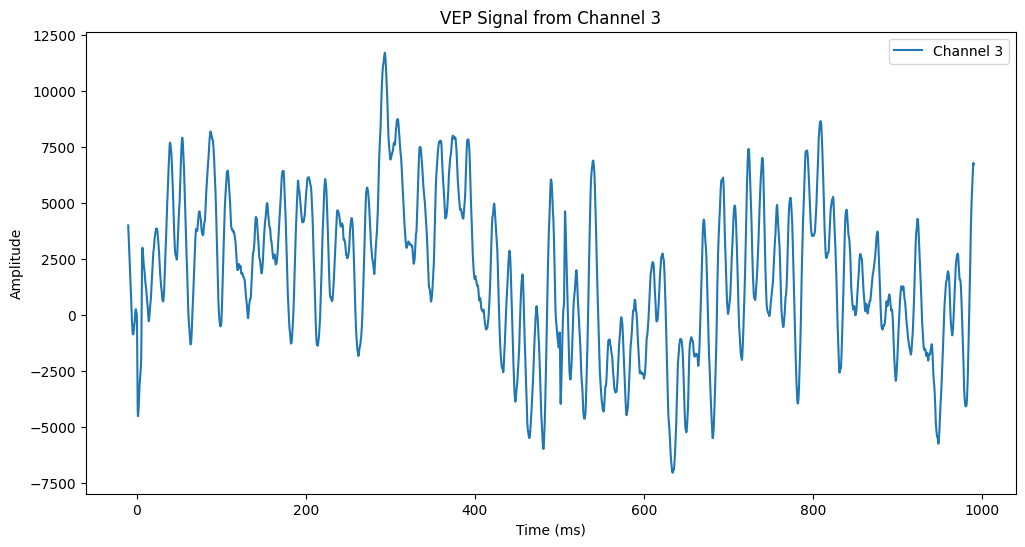

In [6]:
# use ch3 as signal
signal = df['Chan 3'].values
time = df['Step 1'].values

plt.figure(figsize=(12, 6))
plt.plot(time, signal, label='Channel 3')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('VEP Signal from Channel 3')
plt.show()

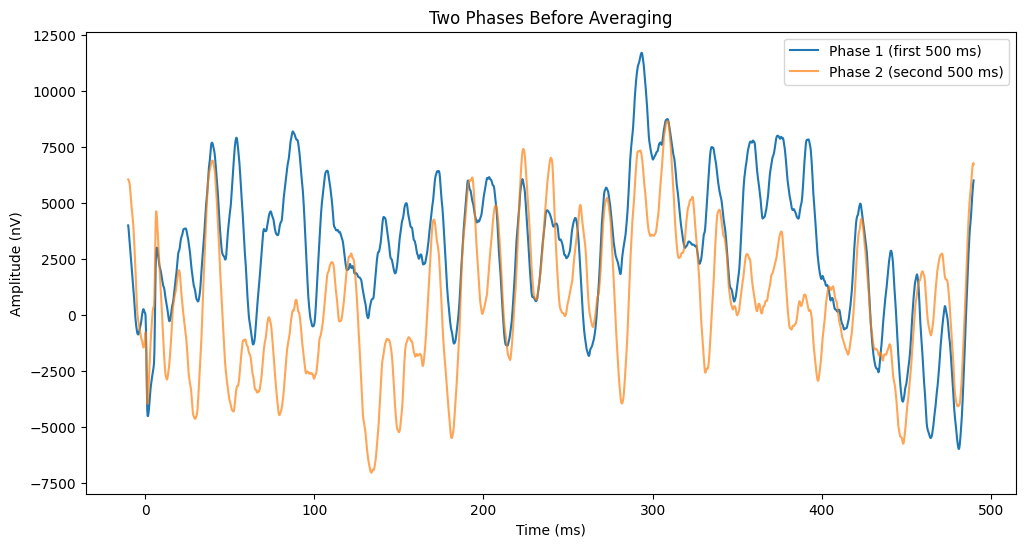

In [7]:
def plot_two_phases(signal, time):
    N = len(signal) // 2

    # split signal
    sig1 = signal[:N]
    sig2 = signal[N:2*N]

    # time axes (MATLAB assumes identical time for both phases)
    t1 = time[:N]
    t2 = time[:N]      # don't use the second one — MATLAB discards it

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(t1, sig1, label='Phase 1 (first 500 ms)')
    plt.plot(t2, sig2, label='Phase 2 (second 500 ms)', alpha=0.7)
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (nV)")
    plt.title("Two Phases Before Averaging")
    plt.legend()
    plt.show()


# --- Call the function ---
plot_two_phases(signal, time)

## 1. Average Two phases

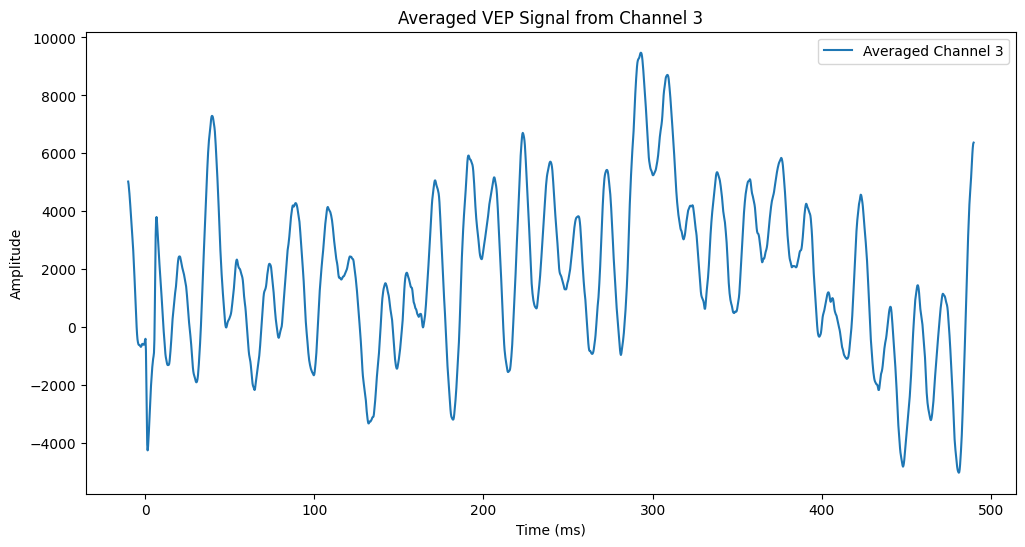

In [8]:
# 1.average two phases (500ms chunks)  
def average_two_phases(signal, time):
    N = len(signal) // 2
    # split signal
    sig1 = signal[:N]
    sig2 = signal[N:2*N]
    # average
    signal_avg = (sig1 + sig2) / 2
    time_avg   = time[:N]     
    return signal_avg, time_avg

# average ch3 signal
ch3_avg, time_avg = average_two_phases(df['Chan 3'].values, df['Step 1'].values)

plt.figure(figsize=(12, 6))
plt.plot(time_avg, ch3_avg, label='Averaged Channel 3')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Averaged VEP Signal from Channel 3')
plt.show()

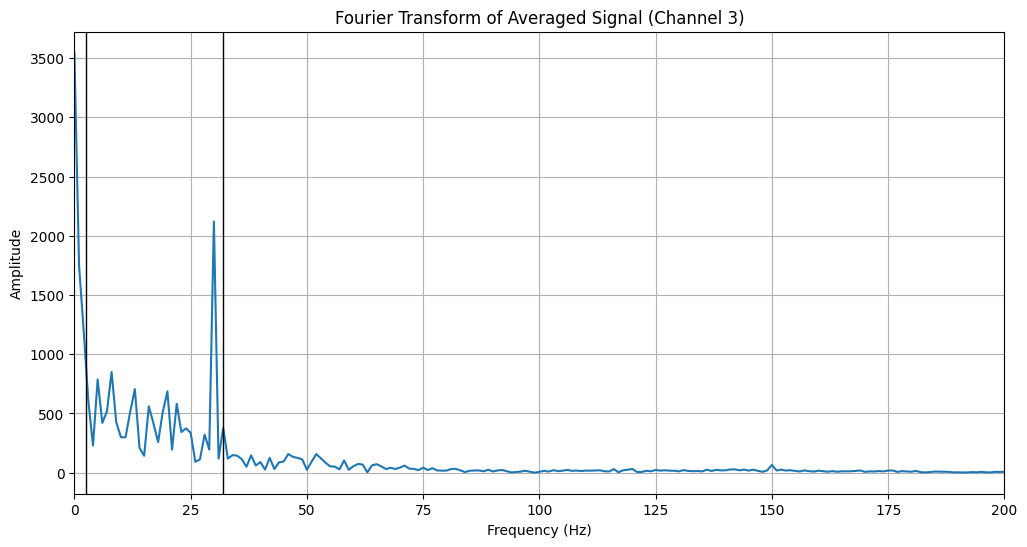

Peak frequency between 0-3Hz: 0.0 Hz


In [9]:
# show Fourier Transform of averaged signal (frequency comonents)
from scipy.fft import fft, fftfreq
N = len(ch3_avg)
fs = 2000  # Sampling frequency
yf = fft(ch3_avg)
xf = fftfreq(N, 1/fs)[:N//2]
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.axvline(32, color='black', lw=1)
plt.axvline(2.5, color='black', lw=1)
plt.title('Fourier Transform of Averaged Signal (Channel 3)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 200)  # Focus on lower frequencies
plt.grid()
plt.show()

# find peak between 0-3Hz in spectrum 
from scipy.signal import butter, filtfilt, iirnotch
# Find peak between 0-3Hz in spectrum
peak_freq = xf[np.argmax(2.0/N * np.abs(yf[0:N//2]))]
print(f"Peak frequency between 0-3Hz: {peak_freq} Hz")

## 3. Detrend

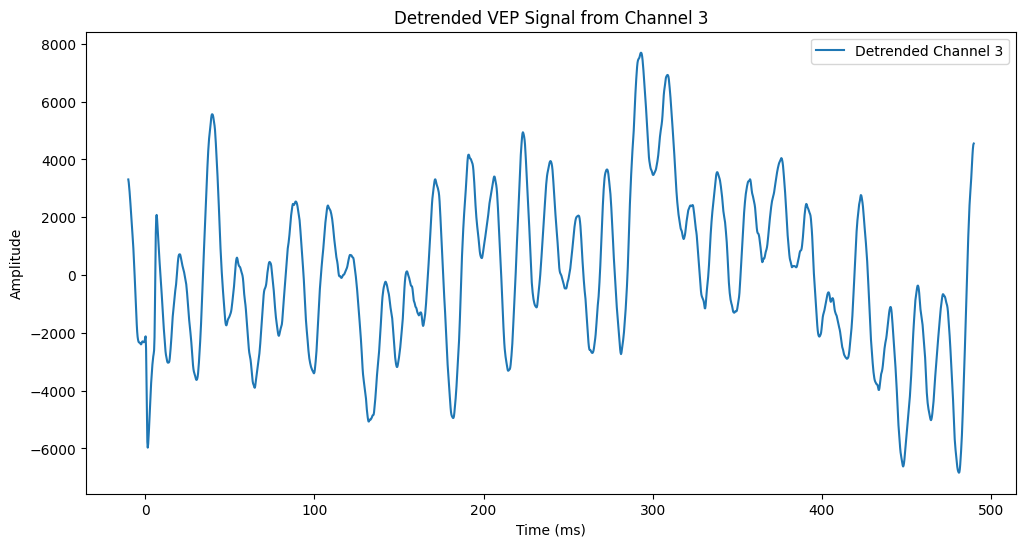

In [10]:
from scipy.signal import detrend

def detrend_signal(signal):
    return detrend(signal)

detrended_ch3 = detrend_signal(ch3_avg)
plt.figure(figsize=(12, 6))
plt.plot(time_avg, detrended_ch3, label='Detrended Channel 3')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Detrended VEP Signal from Channel 3')
plt.show()

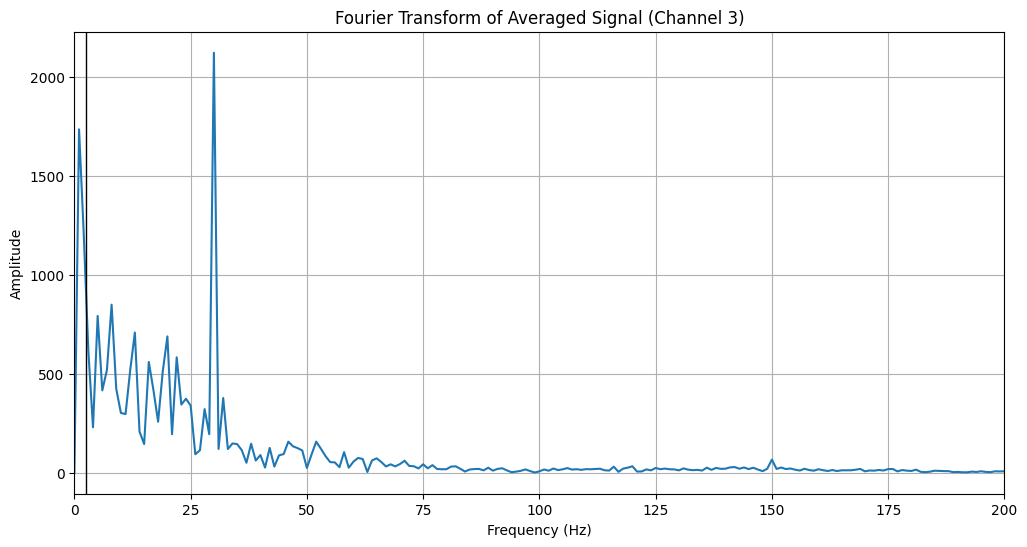

Peak frequency between 0-3Hz: 30.0 Hz


In [11]:
# show Fourier Transform of averaged signal (frequency comonents)
from scipy.fft import fft, fftfreq
N = len(detrended_ch3)
fs = 2000  # Sampling frequency
yf = fft(detrended_ch3)
xf = fftfreq(N, 1/fs)[:N//2]
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.axvline(2.5, color='black', lw=1)
plt.title('Fourier Transform of Averaged Signal (Channel 3)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 200)  # Focus on lower frequencies
plt.grid()
plt.show()

# find peak between 0-3Hz in spectrum 
from scipy.signal import butter, filtfilt, iirnotch
# Find peak between 0-3Hz in spectrum
peak_freq = xf[np.argmax(2.0/N * np.abs(yf[0:N//2]))]
print(f"Peak frequency between 0-3Hz: {peak_freq} Hz")

## 2. Filtering

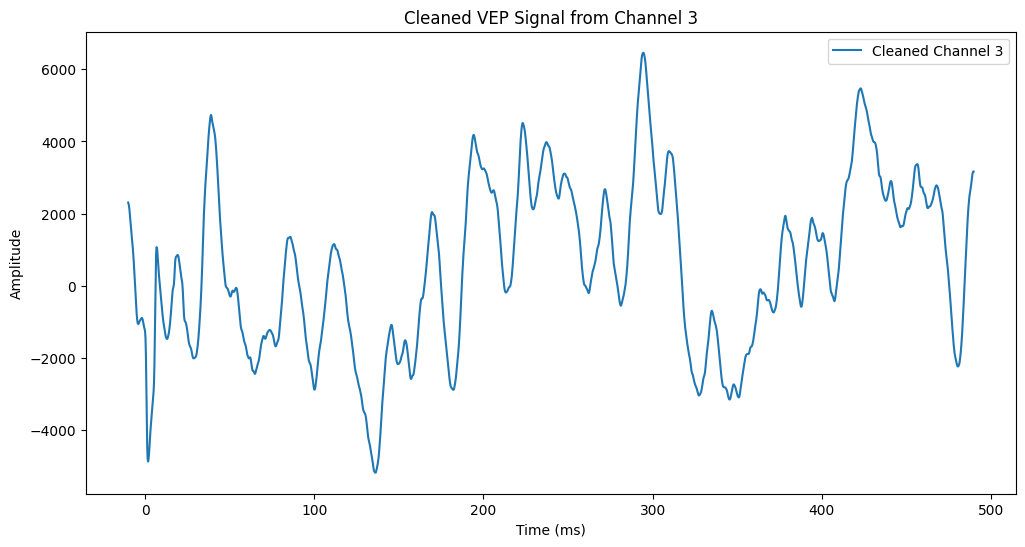

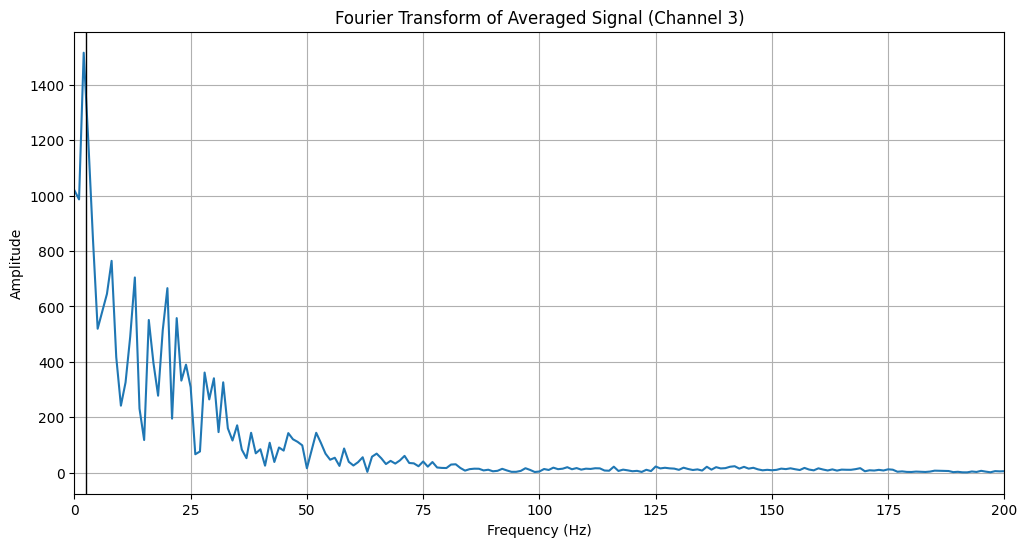

Peak frequency between 0-3Hz: 2.0 Hz


In [12]:
from scipy.signal import iirnotch, filtfilt
import numpy as np

def remove_artifacts(signal, fs=2000, freq=2.5, cf=30):
    # narrow filter (notch) to remove artifact at 'freq' Hz
    low = freq - 0.5     # small margin
    high = freq + 0.5
    low /= fs/2
    high /= fs/2

    b, a = butter(2, [low, high], btype='bandstop')
    filtered = filtfilt(b, a, signal)

    # remove carrier frequency (cf) with notch filter
    nyquist = fs / 2
    freqs = np.arange(cf, nyquist, cf)

    for f0 in freqs:
        # Q determines notch sharpness
        Q = 30.0
        w0 = f0 / nyquist
        b, a = iirnotch(w0, Q)
        filtered = filtfilt(b, a, filtered)
    return filtered

cleaned_ch3 = remove_artifacts(detrended_ch3, fs=2000, freq=2.5)

plt.figure(figsize=(12, 6))
plt.plot(time_avg, cleaned_ch3, label='Cleaned Channel 3')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Cleaned VEP Signal from Channel 3')
plt.show()


# show Fourier Transform of averaged signal (frequency comonents)
N = len(cleaned_ch3)
fs = 2000  # Sampling frequency
yf = fft(cleaned_ch3)
xf = fftfreq(N, 1/fs)[:N//2]
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.axvline(2.5, color='black', lw=1)
plt.title('Fourier Transform of Averaged Signal (Channel 3)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 200)  # Focus on lower frequencies
plt.grid()
plt.show()


peak_freq = xf[np.argmax(2.0/N * np.abs(yf[0:N//2]))]
print(f"Peak frequency between 0-3Hz: {peak_freq} Hz")

In [13]:
import os
def extract_PulseWidth_SignalPower(filename):
    name = os.path.splitext(os.path.basename(filename))[0]
    parts = name.split("_")
    #  FIND PART THAT CONTAINS "ms"
    pulsePart = None
    pulseIndex = None

    for i, p in enumerate(parts):
        if "ms" in p.lower():
            pulsePart = p
            pulseIndex = i
            break

    if pulsePart is None:
        raise ValueError(f"No pulse width ('ms') found in filename: {filename}")
    #  Special case: pulse width split into '0' + '5ms'

    if pulseIndex == 3 and parts[pulseIndex - 1] == '0':
        # combine "0" and "5ms" → "0_5ms"
        pulsePart = f"{parts[pulseIndex - 1]}_{parts[pulseIndex]}"

    # remove "ms"
    pulsePart = pulsePart.replace("ms", "")

    # replace "_" with "." → matches MATLAB strrep
    pulsePart = pulsePart.replace("_", ".")

    # convert to float
    try:
        pulseWidth = float(pulsePart)
    except ValueError:
        raise ValueError(f"Could not parse pulse width from: {pulsePart} (file: {filename})")

    #  Extract irradiance / power
    # last item: e.g., "0.60mWmm2"
    signalPart = parts[-1].replace("mWmm2", "")

    try:
        signalPower = float(signalPart)
    except ValueError:
        raise ValueError(f"Could not parse signal power from: {signalPart} (file: {filename})")

    return pulseWidth, signalPower

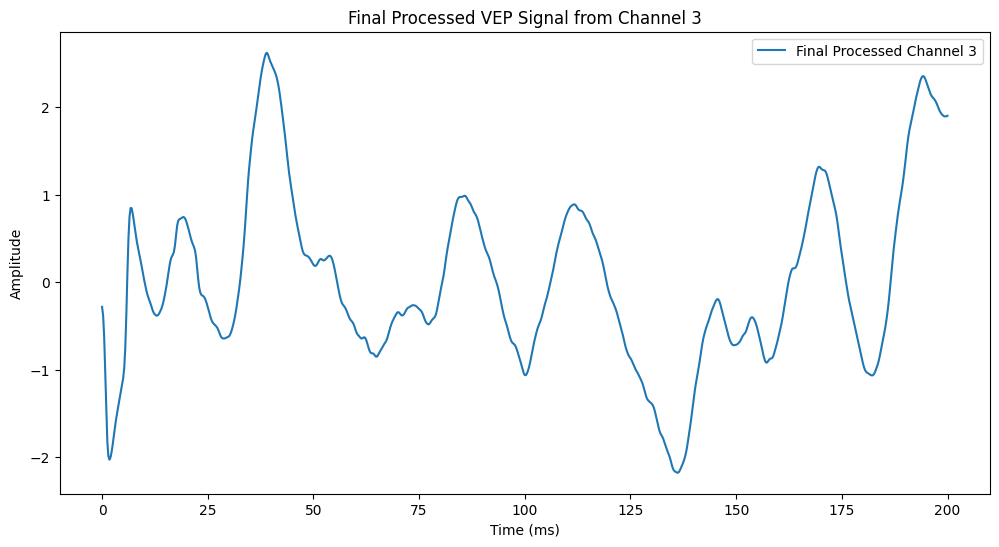

In [14]:
# 5. Custom artifact removal

def artifact_removal_normalized(signal, time, filepath, delay=0, t_max=200, normalize=False):
    # extract pulse_width (duration), but do not use it as a time shift
    pulse_width, _ = extract_PulseWidth_SignalPower(filepath)

    # find index AFTER stimulus ends
    idx_after_pulse = np.where(time > pulse_width)[0][0]

    # align so that signal after pulse is zero
    signal = signal - signal[idx_after_pulse]

    # shift time so that stim onset is at 0 ms
    time = time + delay

    # trim to [0, t_max]
    mask = (time >= 0) & (time <= t_max)
    signal = signal[mask]
    time = time[mask]

    # only normalize if explicitly desired
    if normalize:
        signal = (signal - np.mean(signal)) / np.std(signal)

    return time, signal


time_final, signal_final = artifact_removal_normalized(
    cleaned_ch3,
    time_avg,
    test_file,
    delay=0,
    t_max=200,
    normalize=True
)


plt.figure(figsize=(12, 6))
plt.plot(time_final, signal_final, label='Final Processed Channel 3')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Final Processed VEP Signal from Channel 3')
plt.show()
